TODO:
- Finish revising the grains of the main dataframes.
- Let the user select a period as a continuous range of whole days.
- Set the notebook up to ingest TOS data from CSV files.
- Incorporate documentation

In [425]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
from datetime import time

In [441]:
def dwell_times(container_times, sampling_interval, first_day, last_day):

    def plot_segments(segments, x1, x2, y1, y2, xTitle, yTitle, plotTitle, color, show, time_start, time_end):
        # Create the plot object
        for i in range(len(segments)):
            plt.plot([segments.loc[i, x1], segments.loc[i, x2]]
                      , [segments.loc[i, y1], segments.loc[i, y2]]
                     , color=color)
        
        # Display the plot
        plt.xticks(rotation=90)
        plt.xlim(time_start, time_end)
        plt.xlabel(xTitle)
        plt.ylabel(yTitle)
        plt.title(plotTitle)
        if show:
            plt.show()
        return plt

    def return_zero_for_div_by_zero(numerators, divisors):
        return [num / div if div != 0 else 0 for num, div in zip(numerators, divisors)]

    # The users can input a time table of arrivals and departures for containers. The users can also
    # select dates that they are interested in. This is so that we can eventually supply a list of
    # all the containers that were on the terminal for those dates and report metrics only for those
    # dates instead of from the earliest event to the latest.

    # The integration method needs a dataframe with a grain of one row per interval between inventory
    # change events per day. If an interval stretches over two or more days, then it needs to be split.

    # The sampling method needs a dataframe with a grain of one row per sample.

    # The ratio method needs a dataframe with a grain of one row per container per day.

    # The mainsail method needs a dataframe with a grain of one row per container. Selection of rows will
    # be used to get individual days.

    # Let's setup the user-input data.

    container_times_df = pd.DataFrame(container_times)
    print(container_times_df)
    container_times_df['arrival'] = container_times_df['arrival'].apply(lambda x: pd.to_datetime(x))
    container_times_df['departure'] = container_times_df['departure'].apply(lambda x: pd.to_datetime(x))
    container_times_df['dwell'] = container_times_df['departure'] - container_times_df['arrival']

    # And the rest of the user input
    sampling_timedelta = pd.Timedelta(hours=3)
    start_time = pd.to_datetime(first_day)
    end_time = pd.to_datetime(last_day) + pd.Timedelta(days=1) - pd.Timedelta(seconds=1)
    first_day = start_time.date()
    last_day = end_time.date()
    date_df = pd.DataFrame(pd.date_range(start=first_day, end=last_day), columns=['day_actual'])
    period = end_time - start_time
    
    # To create the integration dataframe with a grain of one row per interval between inventory change
    # events per day, I need to create an event list and then join it to itself, shifting by one row,
    # to get intervals.

    # Building the integration dataframe first is a good choice. We'll use it to produce the plots too.

    # Let's unpivot the input time table to get arrival and departure events.
    integration_df = pd.melt(
        pd.DataFrame(container_times_df)
        , id_vars=['container']
        , value_vars=['arrival', 'departure']
        , var_name='event_type'
        , value_name='event_time'
    )
    integration_df = integration_df.sort_values(by='event_time', ascending=True)
    integration_df['box_count_incr'] = (
        integration_df['event_type'].apply(lambda x: 1 if x == 'arrival' else -1)
    )
    integration_df['box_count'] = integration_df['box_count_incr'].cumsum()
    integration_df['event_start_day'] = pd.to_datetime(integration_df['event_time']).apply(lambda x: x.date())
    integration_df['next_container'] = integration_df['container'].shift(-1)
    integration_df['next_event_type'] = integration_df['event_type'].shift(-1)
    integration_df['next_event_time'] = integration_df['event_time'].shift(-1)
    integration_df['event_end_day'] = pd.to_datetime(integration_df['next_event_time'].apply(lambda x: x.date()))
    # At this point, let's split the intervals by day.
    conn = sqlite3.connect(':memory:')
    integration_df.to_sql('integration_df', conn, index=False)
    date_df.to_sql('date_df', conn, index=False)
    query = '''
        select *
        from integration_df
        inner join date_df on
            date_df.day_actual between integration_df.event_start_day and integration_df.event_end_day
    '''
    integration_df = pd.read_sql_query(query, conn)
    integration_df['event_time'] = integration_df['event_time'].apply(lambda x: pd.to_datetime(x))
    integration_df['event_start_day'] = integration_df['event_start_day'].apply(lambda x: pd.to_datetime(x))
    integration_df['next_event_time'] = integration_df['next_event_time'].apply(lambda x: pd.to_datetime(x))
    integration_df['event_end_day'] = integration_df['event_end_day'].apply(lambda x: pd.to_datetime(x))
    integration_df['day_actual'] = integration_df['day_actual'].apply(lambda x: pd.to_datetime(x))
    integration_df['interval_start_time'] = np.maximum(integration_df['event_time'], integration_df['day_actual'])
    integration_df['interval_end_time'] = np.minimum(integration_df['next_event_time'], integration_df['day_actual'] + pd.Timedelta(days=1))
    integration_df['duration'] = integration_df['interval_end_time'] - integration_df['interval_start_time']
    # The dwell_rise is the amount of dwell time gained during the intervals. It's the product of the box count and the duration.
    integration_df['dwell_rise'] = integration_df['duration'] * integration_df['box_count']
    # Here I need to merge the container_times_df so that I can get the dwell for each container for the entire visit.
    # I need the dwell for each container for the entire visit so that I can subtract the dwell time out of the cumulative sum
    # when the container departs.
    integration_df = pd.merge(integration_df, container_times_df, on='container', how='inner')
    integration_df['dwell_loss'] = (
        integration_df.apply(
            lambda row: -1 * row['dwell']
                if (row['event_type'] == 'departure') & (row['event_start_day'] == row['day_actual'])
                else pd.to_timedelta(0)
            , axis=1
        )
    )
    # The dwell time increment for the interval is the sum of the dwell_rise and the dwell_loss.
    integration_df['dwell_incr'] = integration_df['dwell_rise'] + integration_df['dwell_loss']
    # The cumulative sum is a handy way to get the total dwell at the end of the interval.
    # Since we don't start with an empty yard, we need to add the initial total dwell.
    initial_total_dwell = container_times_df['arrival'].apply(lambda x: np.maximum(start_time - x, pd.Timedelta(0))).sum()
    integration_df['ending_dwell'] = integration_df['dwell_incr'].cumsum() + initial_total_dwell
    # And the starting dwell can be obtained easily enough be subtracting the dwell_rise.
    integration_df['starting_dwell'] = integration_df['ending_dwell'] - integration_df['dwell_rise']
    # The average dwell at the end points of the interval can be computed from the total dwell 
    # by dividing by the box count.
    integration_df['starting_avg_dwell'] = integration_df['starting_dwell'] / integration_df['box_count']
    integration_df['starting_avg_dwell'] = integration_df['starting_avg_dwell'].apply(lambda x: x.total_seconds() / 3600)
    integration_df['ending_avg_dwell'] = integration_df['ending_dwell'] / integration_df['box_count']
    integration_df['ending_avg_dwell'] = integration_df['ending_avg_dwell'].apply(lambda x: x.total_seconds() / 3600)
    integration_df['avg_dwell_rise'] = integration_df['ending_avg_dwell'] - integration_df['starting_avg_dwell']

    # Let's produce the plots now.
    segments = integration_df.copy()
    segments = segments.drop(columns=[
                        'container','event_type','box_count_incr'
                        ,'next_container','next_event_type','duration','dwell_rise'
                        ,'arrival','departure','dwell','dwell_loss'
                        ,'dwell_incr','day_actual'
                        ,'event_time','event_start_day','next_event_time','event_end_day'])
    segments['starting_dwell'] = segments['starting_dwell'].apply(lambda x: x.total_seconds())/3600
    segments['ending_dwell'] = segments['ending_dwell'].apply(lambda x: x.total_seconds())/3600

    # Total dwell time plot
    plot_segments(segments, 'interval_start_time', 'interval_end_time', 'starting_dwell', 'ending_dwell',
                  'Time (hours)', 'Total Dwell (hours)', 'Total Dwell Time Over Time', '#36454F', True, start_time, end_time)

    # Box count plot
    plot_segments(segments, 'interval_start_time', 'interval_end_time', 'box_count', 'box_count',
                  'Time (hours)', 'Container Count', 'Container Count Over Time', '#36454F', True, start_time, end_time)

    # Let's produce the sampling times and sampled avg dwells for overlay on the avg dwell plot next.
    # The sample_offset let's us sample in the middle of the interval instead of at the beginning.
    sample_offset = sampling_timedelta / 2
    sampling_times = pd.date_range(start=(start_time + sample_offset), end=end_time, freq=sampling_timedelta)
    sampling_df = pd.DataFrame(sampling_times, columns=['sampling_time'])
    # Joining the samples to the segments
    sampling_df.to_sql('sampling_df', conn, index=False)
    segments.to_sql('segments', conn, index=False)
    query = '''
        select *
        from sampling_df
        left join segments on
            sampling_df.sampling_time between segments.interval_start_time and segments.interval_end_time
    '''
    sampling_df = pd.read_sql_query(query, conn)
    # Use linear interpolation to obtain the sampled avg dwell time
    sampling_df['sample_dwell'] = (
        sampling_df['starting_avg_dwell'] +
        (sampling_df['sampling_time'].apply(pd.to_datetime) -
         sampling_df['interval_start_time'].apply(pd.to_datetime)).apply(lambda x: x.total_seconds() / 3600)
    )
    sampling_df['sampling_time'] = pd.to_datetime(sampling_df['sampling_time'])
    # If there's no data, let the sample be 0.
    sampling_df['sample_dwell'] = sampling_df['sample_dwell'].fillna(0)
    
    # Avg dwell time plot
    avg_dwell_plot = plot_segments(segments, 'interval_start_time', 'interval_end_time', 'starting_avg_dwell', 'ending_avg_dwell',
                  'Time (hours)', 'Avg Dwell (hours)', 'Avg Dwell Time Over Time and Sampled Points', '#36454F', False, start_time, end_time)
    avg_dwell_plot.scatter(sampling_df['sampling_time'], sampling_df['sample_dwell'], color='#36454F', label='Sampling Points')
    avg_dwell_plot.show()

    ## Now time to compute results
    # results_df = pd.DataFrame(columns=['Method', 'Timeframe', 'Value'])
    
    # Integration results
    integration_df['duration_hours'] = integration_df['duration'].apply(lambda x: x.total_seconds())/3600
    integration_df['area'] = (
        integration_df['starting_avg_dwell'] * integration_df['duration_hours']
            + 0.5 * integration_df['duration_hours'] * integration_df['avg_dwell_rise']
        # Need avg_dwell_rise here because if there are not boxes, it's zero.
    )
    integration_result_all = round(integration_df['area'].sum() / ((end_time - start_time).total_seconds()/3600), 1)
    
    daily_integration_results = integration_df.groupby('day_actual')['area'].sum().reset_index()
    daily_integration_results['avg_dwell'] = round(daily_integration_results['area']/24.0, 1)
    daily_integration_results['Method'] = 'Integration'
    daily_integration_results['Timeframe'] = daily_integration_results['day_actual']
    daily_integration_results['Avg Dwell'] = daily_integration_results['avg_dwell']
    daily_integration_results = daily_integration_results.drop(columns=['day_actual', 'avg_dwell', 'area'])
    
    integration_result_avg = daily_integration_results['Avg Dwell'].mean()
    
    results_df = pd.DataFrame([{'Method': 'Integration', 'Timeframe': 'Entire Period', 'Avg Dwell': integration_result_all}])
    results_df = pd.concat([results_df, daily_integration_results], ignore_index = True)
    results_df = pd.concat(
        [results_df
         , pd.DataFrame([{
             'Method': 'Integration'
             , 'Timeframe': 'Avg Over Days'
             , 'Avg Dwell': integration_result_avg
         }])]
        , ignore_index = True
    )
        
    # Sampling results
    sampling_result = round(sampling_df['sample_dwell'].mean(), 1)
    
    sampling_df['day_actual'] = sampling_df['sampling_time'].apply(lambda x: x.date())
    daily_sampling_results = sampling_df.groupby('day_actual')['sample_dwell'].mean().reset_index()
    daily_sampling_results = daily_sampling_results.rename(columns={'day_actual': 'Timeframe', 'sample_dwell': 'Avg Dwell'})
    daily_sampling_results['Method'] = 'Sampling'
    
    daily_sampling_avg = daily_sampling_results['Avg Dwell'].mean()

    results_df = pd.concat(
        [results_df
         , pd.DataFrame([{
             'Method': 'Sampling'
             , 'Timeframe': 'Entire Period'
             , 'Avg Dwell': sampling_result
         }])]
        , ignore_index = True
    )
    results_df = pd.concat([results_df, daily_sampling_results], ignore_index = True)
    results_df = pd.concat(
        [results_df
         , pd.DataFrame([{
             'Method': 'Sampling'
             , 'Timeframe': 'Avg Over Days'
             , 'Avg Dwell': daily_sampling_avg
         }])]
        , ignore_index = True
    )
    
    # Ratio results
    # The ratio method needs a dataframe with a grain of one row per container per day.
    ratio_df = container_times_df.copy()
    ratio_df['dwell'] = ratio_df['dwell'].apply(lambda x: x.total_seconds())/3600
    ratio_df['dwell_start_day'] = ratio_df['arrival'].apply(lambda x: x.date())
    ratio_df['dwell_end_day'] = ratio_df['departure'].apply(lambda x: x.date())
    ratio_df.to_sql('ratio_df', conn, index=False)
    query = '''
        select ratio_df.*, date(date_df.day_actual) as day_actual
        from ratio_df
        inner join date_df on date(date_df.day_actual) between ratio_df.dwell_start_day and ratio_df.dwell_end_day
    '''
    ratio_df = pd.read_sql_query(query, conn)
    ratio_df['arrival'] = ratio_df['arrival'].apply(lambda x: pd.to_datetime(x))
    ratio_df['departure'] = ratio_df['departure'].apply(lambda x: pd.to_datetime(x))
    ratio_df['dwell'] = round(ratio_df['dwell'], 1)
    ratio_df['dwell_start_day'] = ratio_df['dwell_start_day'].apply(lambda x: pd.to_datetime(x).date())
    ratio_df['dwell_end_day'] = ratio_df['dwell_end_day'].apply(lambda x: pd.to_datetime(x).date())
    ratio_df['day_actual'] = ratio_df['day_actual'].apply(lambda x: pd.to_datetime(x).date())

    # TODO: compute average dwell for each container on each day; average box count on each day; take the ratio for each Timeframe
    
    with pd.option_context('display.max_columns', None):
        print('ratio_df:\n', ratio_df, '\n')
        print('results_df:\n', results_df, '\n')
    """
    #container_times['DwellAreas'] = 0.5 * (((container_times['Departures'] - container_times['Arrivals']).apply(lambda x: x.total_seconds()/3600)) ** 2)
    #container_times['BoxCountAreas'] = (container_times['Departures'] - container_times['Arrivals']).apply(lambda x: x.total_seconds()/3600)
    #ratio_result = round(container_times['DwellAreas'].sum() / container_times['BoxCountAreas'].sum(), 1)
    
    # Mainsail result - entire period
    mainsail_container_times = container_times.copy()
    mainsail_container_times = (
        mainsail_container_times[
            (mainsail_container_times['Arrivals'].apply(lambda x: x.date() >= first_day))
            & (mainsail_container_times['Departures'].apply(lambda x: x.date() <= last_day))
        ]
    )
    mainsail_result = (
        round(
            (mainsail_container_times['Departures'] - mainsail_container_times['Arrivals'])
                .apply(lambda x: x.total_seconds()/3600).sum()
                / mainsail_container_times.shape[0]
            , 1
        )
    )
    
    ## Daily results
    event_list_days = pd.melt(container_times, id_vars=['Container'], value_vars=['Arrivals', 'Departures'], var_name='Event Type', value_name='Time')

    num_days = (last_day - first_day).days + 1
    days = pd.date_range(start=first_day, end=last_day)
    days = [pd.to_datetime(date) for date in days]
    new_events = pd.DataFrame({
        'Container': [None for _ in range(num_days)],
        'Event Type': ['Day Change' for _ in range(num_days)],
        'Time': [days[i] for i in range(num_days)]
    })
    new_events = new_events[1:] # Don't want the starting or ending day change

    event_list_days = pd.concat([event_list_days, new_events], ignore_index=True)
    event_list_days = event_list_days.sort_values(by=['Time', 'Event Type'], ascending=[True, False])
    event_list_days['Box_Count_Incr'] = event_list_days['Event Type'].apply(lambda x: 1 if x == 'Arrivals' else -1 if x == 'Departures' else 0)
    event_list_days['Box_Count'] = event_list_days['Box_Count_Incr'].cumsum()
    event_list_days['Next Container'] = event_list_days['Container'].shift(-1)
    event_list_days['Next Event Type'] = event_list_days['Event Type'].shift(-1)
    event_list_days['Next Event Time'] = event_list_days['Time'].shift(-1)
    event_list_days['Duration'] = event_list_days['Next Event Time'] - event_list_days['Time']
    
    daily_intervals = event_list_days.copy()
    daily_intervals = daily_intervals.dropna(subset=['Next Event Time']).copy()
    daily_intervals['Dwell Rise'] = daily_intervals['Duration'] * daily_intervals['Box_Count']
    trimmed_container_times = container_times[['Container', 'Dwell']]
    daily_intervals = pd.merge(daily_intervals, trimmed_container_times, on='Container', how='left')
    daily_intervals['Dwell Loss'] = daily_intervals.apply(lambda row: -1 * row['Dwell'] if row['Event Type'] == 'Departures' else pd.Timedelta(0), axis=1)
    daily_intervals['Dwell Incr'] = daily_intervals['Dwell Rise'] + daily_intervals['Dwell Loss']
    daily_intervals['Ending Dwell'] = daily_intervals['Dwell Incr'].cumsum()
    daily_intervals['Starting Dwell'] = daily_intervals['Ending Dwell'] - daily_intervals['Dwell Rise']
    daily_intervals['Starting Avg Dwell'] = pd.to_timedelta(return_zero_for_div_by_zero(daily_intervals['Starting Dwell'], daily_intervals['Box_Count']))
    daily_intervals['Ending Avg Dwell'] = pd.to_timedelta(return_zero_for_div_by_zero(daily_intervals['Ending Dwell'], daily_intervals['Box_Count']))
    daily_intervals['Avg Dwell Rise'] = daily_intervals['Ending Avg Dwell'] - daily_intervals['Starting Avg Dwell']
    daily_intervals['Areas'] = (
        (daily_intervals['Starting Avg Dwell'].apply(lambda x: x.total_seconds()/3600))
                 * (daily_intervals['Duration'].apply(lambda x: x.total_seconds()/3600))
            + 0.5
                * (daily_intervals['Duration'].apply(lambda x: x.total_seconds()/3600))
                * (daily_intervals['Avg Dwell Rise'].apply(lambda x: x.total_seconds()/3600))
    )
    daily_intervals['Day'] = daily_intervals['Time'].apply(lambda x: x.date())

    # Integration result for the entire period
    period_intervals = daily_intervals.copy()
    period_intervals = (
        period_intervals[
            (period_intervals['Time'].apply(lambda x: x.date() >= first_day))
            & (period_intervals['Next Event Time'].apply(lambda x: x.date() <= last_day))
        ]
    )
    integration_result = round(period_intervals['Areas'].sum() / (num_days * 24.0), 1)
    
    # Daily integration results
    daily_integration_results = period_intervals.groupby('Day').agg({'Areas': 'sum', 'Duration': 'sum', 'Time': 'count'}).reset_index()
    daily_integration_results = daily_integration_results.rename(columns={
        'Areas': 'Total_Areas',
        'Duration': 'Total_Duration',
        'Time': 'Record_Count'
    })
    daily_integration_results = daily_integration_results[
        ~((daily_integration_results['Total_Duration'] == 0.0) & (daily_integration_results['Record_Count'] == 1))
    ]
    daily_integration_results['avg dwell'] = daily_integration_results['Total_Areas'] / 24  
    filtered_daily_integration_results = daily_integration_results.copy()
    print(filtered_daily_integration_results)
    filtered_daily_integration_results = (
        filtered_daily_integration_results[(
            (filtered_daily_integration_results['Time'].apply(lambda x: x.date() >= first_day))
            & (filtered_daily_integration_results['Next Event Time'].apply(lambda x: x.date() <= last_day))
        )]
    )
    filtered_daily_integration_results['avg dwell'] = filtered_daily_integration_results['avg dwell'].apply(lambda x: round(x, 1))    
    integration_check = round(filtered_daily_integration_results['avg dwell'].mean(), 1)

    # Daily sampling results
    sampling_df = sampling_df.reset_index()
    sampling_df = sampling_df.drop(columns=['index'])
    sampling_df['Day'] = sampling_df['SamplingTime'].apply(lambda x: x.date())

    daily_sampling_results = sampling_df.groupby('Day')['SampleDwell'].mean().reset_index()
    daily_sampling_results = daily_sampling_results.rename(columns={
        'SampleDwell': 'Avg Dwell'
    })
    sampling_check = daily_sampling_results['Avg Dwell'].mean()
    
    # Daily ratio method results
    daily_ratio_results = daily_integration_results[['Day']]
    daily_ratio_results = daily_ratio_results.merge(container_times, how='cross')
    daily_ratio_results = daily_ratio_results.drop(columns=['Dwell', 'DwellAreas', 'BoxCountAreas'])
    daily_ratio_results['Start_of_day'] = daily_ratio_results['Day'].apply(lambda x: pd.to_datetime(x).normalize())
    daily_ratio_results = daily_ratio_results[daily_ratio_results['Departures'] > daily_ratio_results['Start_of_day']]
    daily_ratio_results['End_of_day'] = daily_ratio_results['Start_of_day'].apply(lambda x: x + pd.Timedelta(days=1) - pd.Timedelta(seconds=1))
    daily_ratio_results = daily_ratio_results[daily_ratio_results['Arrivals'] < daily_ratio_results['End_of_day']]
    daily_ratio_results['Daily_dwell_start'] = np.maximum(daily_ratio_results['Arrivals'], daily_ratio_results['Start_of_day'])
    daily_ratio_results['Daily_dwell_end'] = np.minimum(daily_ratio_results['Departures'], daily_ratio_results['End_of_day'])
    daily_ratio_results['Daily_dwell_rise'] = daily_ratio_results['Daily_dwell_end'] - daily_ratio_results['Daily_dwell_start']
    daily_ratio_results['Daily_dwell_final'] = daily_ratio_results.sort_values('Day').groupby('Container')['Daily_dwell_rise'].cumsum()
    daily_ratio_results['Daily_dwell_begin'] = daily_ratio_results['Daily_dwell_final'] - daily_ratio_results['Daily_dwell_rise']
    daily_ratio_results['Daily_avg_dwell'] = (daily_ratio_results['Daily_dwell_final'] + daily_ratio_results['Daily_dwell_begin'])/2
    daily_ratio_results['Avg_dwell_term'] = (
        (daily_ratio_results['Daily_avg_dwell'].apply(lambda x: x.total_seconds()/3600))
            * (daily_ratio_results['Daily_dwell_rise'].apply(lambda x: x.total_seconds()/3600))
            / 24.0
    )
    daily_ratio_results['Avg_box_count_term'] = (
        (daily_ratio_results['Daily_dwell_rise'].apply(lambda x: x.total_seconds()/3600)) / 24.0
    )
    grouped_sum_ratio_results = daily_ratio_results.groupby('Day')[['Avg_dwell_term', 'Avg_box_count_term']].sum()
    grouped_sum_ratio_results['Division'] = grouped_sum_ratio_results['Avg_dwell_term'] / grouped_sum_ratio_results['Avg_box_count_term']
    grouped_sum_ratio_results = (
        grouped_sum_ratio_results[
            (grouped_sum_ratio_results.index >= first_day)
            & (grouped_sum_ratio_results.index <= last_day)
        ]
    )
    daily_ratio_results = (
        daily_ratio_results[
            (daily_ratio_results['Day'] >= first_day)
            & (daily_ratio_results['Day'] <= last_day)
        ]
    )
    ratio_result = daily_ratio_results['Avg_dwell_term'].sum() / daily_ratio_results['Avg_box_count_term'].sum()
    ratio_check = round(grouped_sum_ratio_results['Division'].mean(), 1)

    # Mainsail metric daily results
    mainsail_daily_results = daily_integration_results.copy()
    mainsail_daily_results = mainsail_daily_results.drop(['Total_Areas', 'Total_Duration', 'Record_Count', 'avg dwell'], axis=1)
    mainsail_daily_results = mainsail_daily_results.merge(container_times, how='cross')
    mainsail_daily_results = mainsail_daily_results.drop(columns=['DwellAreas', 'BoxCountAreas'])
    mainsail_daily_results['Day_start'] = mainsail_daily_results['Day'].apply(lambda x: pd.to_datetime(x).normalize())
    mainsail_daily_results['Day_end'] = mainsail_daily_results['Day_start'].apply(lambda x: x + pd.Timedelta(days=1) - pd.Timedelta(seconds=1))
    mainsail_daily_results = (
        mainsail_daily_results[
            (mainsail_daily_results['Arrivals'] >= mainsail_daily_results['Day_start'])
                & (mainsail_daily_results['Departures'] <= mainsail_daily_results['Day_end'])
        ]
    )
    grouped_ms_daily_results = mainsail_daily_results.groupby('Day')['Dwell'].mean().reset_index()
    grouped_ms_daily_results = grouped_ms_daily_results.rename(columns={'Dwell': 'AvgDwell'})
    days_df = grouped_sum_ratio_results.copy()
    days_df = days_df.drop(columns=['Avg_dwell_term', 'Avg_box_count_term', 'Division'])
    mainsail_daily_results = days_df.merge(grouped_ms_daily_results, on='Day', how='left')
    mainsail_daily_results['AvgDwell'] = mainsail_daily_results['AvgDwell'].fillna(pd.to_timedelta(0.0)).apply(lambda x: x.total_seconds())/3600
    mainsail_check = round(mainsail_daily_results['AvgDwell'].mean(), 1)
    
    return (integration_result, daily_integration_results, integration_check, 
            sampling_result, daily_sampling_results, sampling_check, 
            ratio_result, grouped_sum_ratio_results, ratio_check,
            mainsail_result, mainsail_daily_results, mainsail_check)
    """

In [442]:
box_schedules = {
    'container': ['A', 'B', 'C'],
    'arrival': ['2024-09-01 00:00:00', '2024-09-01 12:00:00', '2024-09-02 00:00:00'],
    'departure': ['2024-09-02 12:00:00', '2024-09-03 00:00:00', '2024-09-03 23:59:59']
}

In [443]:
sample_gap = 3

In [444]:
first_day = '2024-09-01'
last_day = '2024-09-03'

  container              arrival            departure
0         A  2024-09-01 00:00:00  2024-09-02 12:00:00
1         B  2024-09-01 12:00:00  2024-09-03 00:00:00
2         C  2024-09-02 00:00:00  2024-09-03 23:59:59


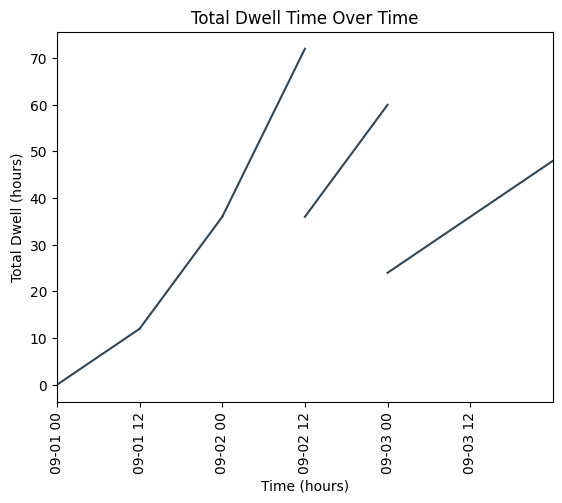

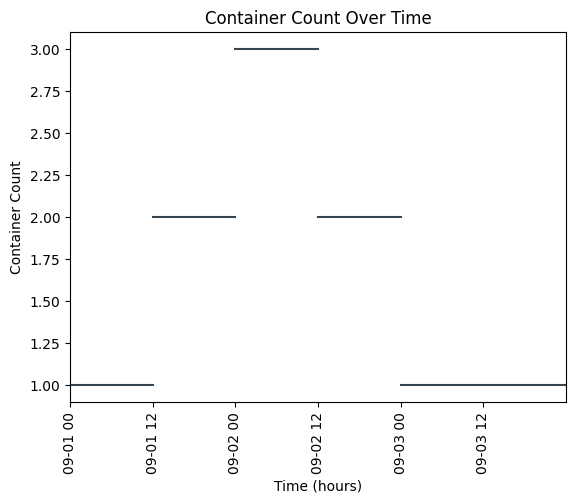

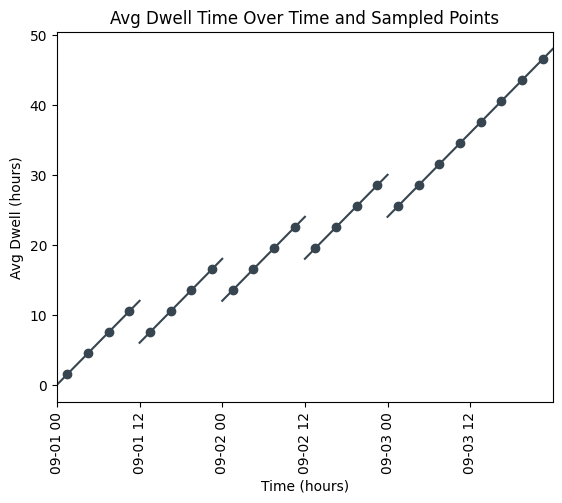

ratio_df:
   container             arrival           departure  dwell dwell_start_day  \
0         A 2024-09-01 00:00:00 2024-09-02 12:00:00   36.0      2024-09-01   
1         A 2024-09-01 00:00:00 2024-09-02 12:00:00   36.0      2024-09-01   
2         B 2024-09-01 12:00:00 2024-09-03 00:00:00   36.0      2024-09-01   
3         B 2024-09-01 12:00:00 2024-09-03 00:00:00   36.0      2024-09-01   
4         B 2024-09-01 12:00:00 2024-09-03 00:00:00   36.0      2024-09-01   
5         C 2024-09-02 00:00:00 2024-09-03 23:59:59   48.0      2024-09-02   
6         C 2024-09-02 00:00:00 2024-09-03 23:59:59   48.0      2024-09-02   

  dwell_end_day  day_actual  
0    2024-09-02  2024-09-01  
1    2024-09-02  2024-09-02  
2    2024-09-03  2024-09-01  
3    2024-09-03  2024-09-02  
4    2024-09-03  2024-09-03  
5    2024-09-03  2024-09-02  
6    2024-09-03  2024-09-03   

results_df:
         Method            Timeframe  Avg Dwell
0  Integration        Entire Period       22.0
1  Integration 

In [445]:
dwell_times(box_schedules, sample_gap, first_day, last_day)